In [2]:
import boto3
import json
from boto3.dynamodb.conditions import Key, Attr
import copy
import argparse
import csv
import pandas as pd
import datetime
import sys
import time
from datetime import datetime
import urllib3
import os
import numpy as np

import random
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from configparser import ConfigParser
import base64
import wordcloud
import math

In [3]:
import nltk
# nltk.download('stopwords') ## Instalar modulo stopwords para nltk
from nltk.corpus import stopwords

In [4]:
dynamodb = boto3.resource('dynamodb', region_name='us-west-2')

In [5]:
s3res = boto3.resource("s3")
s3 = boto3.client("s3")

In [10]:
def obten_lista_transcripts(bucket,prefijo,tipo="texto"):
    ## Obtener textos solos por default

    # archivos = s3.list_objects(Bucket=bucket) 
    # lista_audios = [x["Key"] for x in archivos["Contents"]]

    objetos = s3.list_objects_v2(Bucket=bucket, Prefix=prefijo )
    lista_transcripts = [x["Key"] for x in objetos["Contents"]]

    ## La funcion previa no funciona correctamente el parametro StartAfter
    #lista_transcripts = [y for y in lista_transcripts if ("Transcripts/" in y and "full" not in y )]
    #lista_transcripts = {"texto":y for y in lista_transcripts if len(y) > len(prefijo)}
    lista_transcripts = [y for y in lista_transcripts if len(y) > len(prefijo)]
    lista_transcripts = [dict(s3url=y) for y in lista_transcripts if tipo in y]

    return lista_transcripts

In [11]:
def obten_textos(lista_dict_textos,buckets):
    for transcript in lista_dict_textos:
        #obj = s3.Bucket(buckets).Object(transcript["s3url"])
        obj = s3res.Object(buckets, transcript["s3url"])
        transcript["texto"] = obj.get()['Body'].read().decode('utf-8')
    return lista_dict_textos

In [12]:
lista_trasncripts = obten_lista_transcripts(bucket="voz-salida",prefijo="Transcripts/",tipo="texto")

In [13]:
lista_trasncripts

[{'s3url': 'Transcripts/texto-33-Punto-Quiebre.mp32019-11-04-T-11-37-21.txt'},
 {'s3url': 'Transcripts/texto-ByteNoticias10.mp32019-11-04-T-11-37-23.txt'},
 {'s3url': 'Transcripts/texto-ByteNoticias2.mp32019-11-04-T-11-37-26.txt'}]

In [14]:
lista_trasncripts =  obten_textos(lista_trasncripts,buckets="voz-salida")

In [15]:
lista_trasncripts[0]

{'s3url': 'Transcripts/texto-33-Punto-Quiebre.mp32019-11-04-T-11-37-21.txt',
 'texto': 'escuchas, escuchas son pocas debido Escuchas por dicho Orlin La productora de épocas más importante en las leyes mana. Bueno, pues bienvenidos a este que por razones de viajes de Chava Rock se convierte en el último punto de quiebre del dos mil dieciséis. Señor Milton, Barbosa con la como están ya? Sí, de plano? Si. Sí, verdad? Si es que la capitalidad. Feliz año. No voy a parte Chavarro que se va como cinco semanas haya las argentinas y deberíamos de hacer unos hinchaba rock y solo hablar de Chagall se- Chavarro que del año No, no lo mirarle junto, verdad? Mete hoy el frente tu cámara porque hay? La semana pasada me vino, tengo buen perfil. A- escucharon Jorge alegr Hipólito. Y también está aquí el mismísimo, El único El viaje luchaba. Qué tal? Cómo estamos en las a todos? Bueno, pues se nos fue en dos mil dieciséis. Ya borrador. Digamos patadas este, pero todavía nos quedan los quince de Rubí. Le 

In [16]:
df_transcripts =  pd.DataFrame(lista_trasncripts)
df_transcripts

,s3url,texto
0,Transcripts/texto-33-Punto-Quiebre.mp32019-11-...,"escuchas, escuchas son pocas debido Escuchas p..."
1,Transcripts/texto-ByteNoticias10.mp32019-11-04...,Este es el resumen de noticias tecnológicas y ...
2,Transcripts/texto-ByteNoticias2.mp32019-11-04-...,Este es el resumen de noticias tecnológicas y ...


In [17]:
def removeStopwords( palabras ):
     return " ".join([ word for word in palabras if word not in stopwords.words('spanish') ])

In [18]:
df_transcripts["texto_limpio"] = [removeStopwords(x.split(" ")) for x in df_transcripts.texto]

In [19]:
df_transcripts

,s3url,texto,texto_limpio
0,Transcripts/texto-33-Punto-Quiebre.mp32019-11-...,"escuchas, escuchas son pocas debido Escuchas p...","escuchas, escuchas pocas debido Escuchas dicho..."
1,Transcripts/texto-ByteNoticias10.mp32019-11-04...,Este es el resumen de noticias tecnológicas y ...,Este resumen noticias tecnológicas cultura dig...
2,Transcripts/texto-ByteNoticias2.mp32019-11-04-...,Este es el resumen de noticias tecnológicas y ...,Este resumen noticias tecnológicas cultura dig...


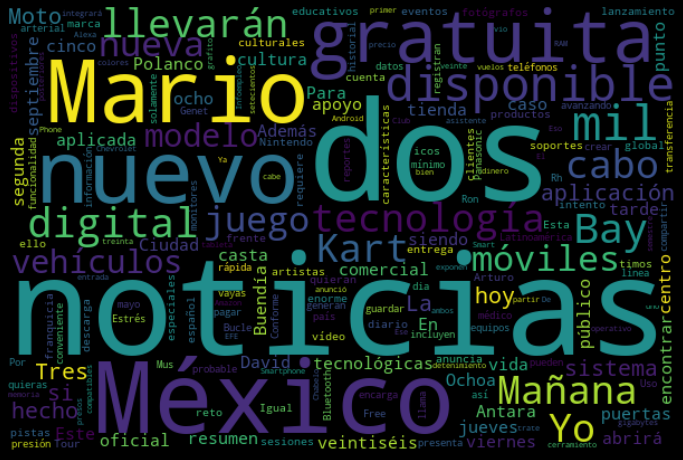

In [26]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib.animation as animation

## DEfinir tamaño de salida
fig = plt.figure(figsize=(12,10))

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

ims = []
#for i in range(30):
#for x in df_transcripts.texto_limpio:
for x in pd.concat([df_transcripts,df_transcripts,df_transcripts]).texto_limpio:
    #im = plt.imshow(f(x, y), animated=True)
    nube = wordcloud.WordCloud(width=600,height=400).generate(x)
    im = plt.imshow(nube, interpolation='bilinear', animated=True)
    plt.axis("off")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=2000, blit=True,repeat_delay=100)

#Guardar en mp4
ani.save('transcripts_wordcloud.mp4')

#plt.show(ani.to_html5_video())
HTML("""
    <video alt="test" controls>
        <source src="transcripts_wordcloud.mp4" type="video/mp4">
    </video>
""")

In [29]:
for i,x in enumerate(pd.concat([df_transcripts,df_transcripts]).texto_limpio):
    print(x)
    print("\n")

escuchas, escuchas pocas debido Escuchas dicho Orlin La productora épocas importante leyes mana. Bueno, pues bienvenidos razones viajes Chava Rock convierte último punto quiebre dos mil dieciséis. Señor Milton, Barbosa ya? Sí, plano? Si. Sí, verdad? Si capitalidad. Feliz año. No voy parte Chavarro va cinco semanas argentinas deberíamos hacer hinchaba rock solo hablar Chagall se- Chavarro año No, mirarle junto, verdad? Mete hoy frente cámara hay? La semana pasada vino, buen perfil. A- escucharon Jorge alegr Hipólito. Y aquí mismísimo, El único El viaje luchaba. Qué tal? Cómo todos? Bueno, pues dos mil dieciséis. Ya borrador. Digamos patadas este, todavía quedan quince Rubí. Le ningún Y quince rugby? Creo sí. Sería mejores cosas usted trozo Años, no? Bueno, impresionante sucede. Dijo tia morriña, sino Papa casa, dicen vaquita chiva, activa diez mil bares. La chiva diez mil bar arreglamos of-. Se va dos mil dieciséis hecho. Además, entrevistas últimas semanas Creo si vemos resúmenes notic